# k-means clustering with scikit-learn

Using kmeans to cluster the digits dataset

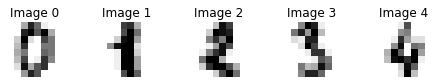

In [6]:
# import standard stuff
import matplotlib.pyplot as plt
import numpy as np

import numpy as np

from sklearn.datasets import load_digits



#import the digits dataset
digits = load_digits()

#look at the first 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 1))
for i in range(5):
    ax = axes[i]
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    title = "Image " + str(digits.target[i])
    ax.set_title(title)

In [7]:
# we can also directly get the X,y feature and target arrays
# if we use "return_X_y = True

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [8]:
# below is a more elaborate example of evaluation of a ML algorithm
# we will use a number of different metrics
# and a pipeline
# data will be pre-processed with StandardScaler, as before

# we will use time to check the run-time of different options
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    
# make a sklearn pipeline
# a pipeline is a sequence of data transformers 
# with an optional final predictor.

    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

# Define the metrics which require only the true labels and estimator
# labels, not the full dataset

# For these scores, 0 is worst and 1 is best

# Homogeneity: Does each cluster only contain members of a single class?
# Completeness: Are all members of a class assigned to a single cluster?
# v-measure combines homogeneity and completeness to a single score
# rand index measures how similar assignments are
# mutual information measures agreement of assignents. adjusted is normalized
# against chance agreements

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

# The silhouette score requires the full dataset and the estimator labels
# it ranges from -1 (bad) to +1 (good) and is based on intra-cluster distance (a)
# and distance to nearest cluster a sample does not belong to (b)
# the score is then (b-a)/max(a,b)

    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

# Show the results as a table using this format string
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))


In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

# we will do the clustering on this data set in three different ways
# we know the number of clusters we are looking for, i.e., 10 for the 10 digits

# "random" just picks k initial centroids at random from the data points
# we do this n_init=4 times
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# k-means++ is a clever way of randomly picking the initial centroids 
# new centroid are chosen based distance-squared to already chosen centers
# we do this n_init=4 times

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# finally, we can use a PCA analysis to help with picking the initial centroids

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random   	0.046s	69735	0.681	0.723	0.701	0.574	0.698	0.178
k-means++	0.038s	69545	0.598	0.645	0.621	0.469	0.617	0.162
PCA-based	0.013s	72713	0.637	0.659	0.648	0.521	0.644	0.144
__________________________________________________________________________________


We would like to plot the data and look at the clusters. But we have 64 features (8x8 pixels). Can't make a 64-dimensional plot...

Solution: Use PCA to find the two most important components. Plot the data and clusters in this 2D space!


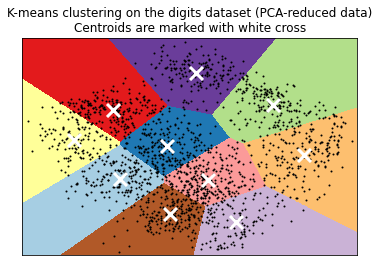

In [10]:
import matplotlib.pyplot as plt

# Do the PCA with 2 components. Each 64-feature point in "data"
# then has a corresponding 2 feature data point in "reduced_data"
reduced_data = PCA(n_components=2).fit_transform(data)

# Run kmeans with the "k-means++" initialization on the reduced data
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Now plot the results in the 2D PCA component space

# Step size of the mesh
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each point
# in the 2D PCA component space

# Get the limits of first component - that will be x-coordinate
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1

# Get the limits of first component - that will be x-coordinate
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

# Make a 2D grid from xmin to xmax and ymin to ymax with stepsize h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh from the model trained on the 
# PCA components. For each x and y coordinate on the grid, the model
# predicts which cluster the (x,y) point belongs to
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1)
# clear the figure
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# plot the data that were transformed into the 2D PCA component space
plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()